In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import math
import time

from skrf import Network

import utils

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Grab the pre-training networks

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
PRE_TRAIN_CHIPS = [1, 2, 3, 5, 6, 7, 10, 14]
TEST_CHIP = 9

# Check out the test data

In [4]:
test_net = utils.get_network_from_file(ROOT_PATH, TEST_CHIP)['network']

In [5]:
out_matrix_re = test_net.s.real
out_matrix_im = test_net.s.imag
out_matrix = np.stack((out_matrix_re, out_matrix_im), axis=-1) #(FREQ, N_PORT, N_PORT, RE/IM)

out_matrix = out_matrix.reshape((out_matrix.shape[0], -1, out_matrix.shape[-1])) #[FREQ, N_PORT^2, RE/IM]
out_matrix = out_matrix.reshape((out_matrix.shape[0], -1)).transpose() #[Re/im Sparams, FREQ]

x_test = out_matrix

In [6]:
print(x_test.shape)

(32, 1000)


In [7]:
N_FREQS = x_test.shape[-1]
print(N_FREQS)

1000


In [8]:
N_PORTS = test_net.nports
print(N_PORTS)

4


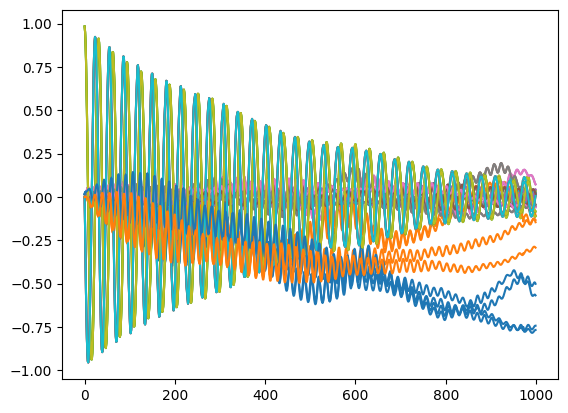

In [9]:
plt.figure()
for i in range(x_test.shape[0]//2):
    plt.plot(x_test[2*i], label=str(i)+" Re")
    plt.plot(x_test[2*i+1], label=str(i)+" Im")
plt.show()

# Make all of the training data at least as long as the test

In [10]:
class Augment(object):
    def __init__(self, output_len = 1000, max_interp = 5):
        self.output_len = output_len
        self.max_interp = max_interp
    
    def __call__(self, data_net):
        """
        Randomly Performs:
            (1) Port Shuffling
            (2) Interpolation by an integer factor

        Then truncates the output to a given length and returns the augmented network. 
        """
        #(1) Shuffle ports
        n_ports = data_net.nports

        from_ports = np.arange(n_ports).tolist()
        to_ports = random.sample(from_ports, len(from_ports))

        net_shuffled = data_net.renumbered(from_ports, to_ports)

        #(3) Interpolate by random factor
        n_points = data_net.frequency.npoints

        min_interp = 1
        if n_points < self.output_len:
            min_interp = int(np.ceil(self.output_len / n_points)) + 1

        interp_fac = random.randint(min_interp, min_interp + self.max_interp)

        if interp_fac > 1:
            new_len = interp_fac * (n_points - 1) + 1
            net_shuffled.resample(new_len)

        #Truncate and return
        return net_shuffled[:self.output_len]


# Make a dataset class for networks

In [11]:
from torch.utils.data import Dataset, DataLoader

class NetworkDataset(Dataset):
    def __init__(self, root_path, chip_nums, transform=None):
        self.root_path = root_path
        self.chip_nums = chip_nums
        self.transform = transform
        
        #Grab all of the network data
        self.data = []

        for CHIP_NUM in chip_nums:
            self.data.append(utils.get_network_from_file(self.root_path, CHIP_NUM)['network'])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        
        out_net = self.data[idx]
        
        if self.transform:
            out_net = self.transform(out_net)
        
        out_matrix_re = out_net.s.real
        out_matrix_im = out_net.s.imag
        out_matrix = np.stack((out_matrix_re, out_matrix_im), axis=-1) #(FREQ, N_PORT, N_PORT, RE/IM)

        out_matrix = out_matrix.reshape((out_matrix.shape[0], -1, out_matrix.shape[-1])) #[FREQ, N_PORT^2, RE/IM]
        out_matrix = out_matrix.reshape((out_matrix.shape[0], -1)).transpose() #[Re/im Sparams, FREQ]

        return out_matrix.astype(np.float32)   

# Scan the training data with and without augmentation

In [12]:
raw_dataset = NetworkDataset(ROOT_PATH, PRE_TRAIN_CHIPS)

for i in range(len(raw_dataset)):
    sample = raw_dataset[i]
    
    print(i, sample.shape, sample.dtype)

0 (32, 501) float32
1 (32, 581) float32
2 (32, 101) float32
3 (32, 1001) float32
4 (32, 501) float32
5 (32, 1000) float32
6 (32, 1000) float32
7 (32, 500) float32


In [13]:
transform = Augment()

transform_dataset = NetworkDataset(ROOT_PATH, PRE_TRAIN_CHIPS, transform)

for i in range(len(transform_dataset)):
    sample = transform_dataset[i]
    
    print(i, sample.shape, sample.dtype)

0 (32, 1000) float32
1 (32, 1000) float32
2 (32, 1000) float32
3 (32, 1000) float32
4 (32, 1000) float32
5 (32, 1000) float32
6 (32, 1000) float32
7 (32, 1000) float32


# 2. Network Setup

## Define network parameters

In [14]:
NC = NZ = x_test.shape[0]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 5

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [15]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  32
NUM_LAYERS:  5
BASE NGF:  64
NC:  32
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False
K:  1
NEW_CAUSAL True


## Init and check dimensions

In [16]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [17]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 32, 1000])


In [18]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  407040


# Define Training Params and Run

In [19]:
LR = 1e-4
NUM_ITER = 1000

PROBLEM_TYPE = "equal"
M_min = 0.01
M_max = 0.1

Sigma_min = 0.01
Sigma_max = 0.05

criterion = nn.MSELoss(reduction="mean")
criterion = criterion.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

loss_list = []

In [20]:
transform = Augment()

train_dataset = NetworkDataset(ROOT_PATH, PRE_TRAIN_CHIPS, transform)

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)

  0%|          | 0/1000 [00:00<?, ?it/s]

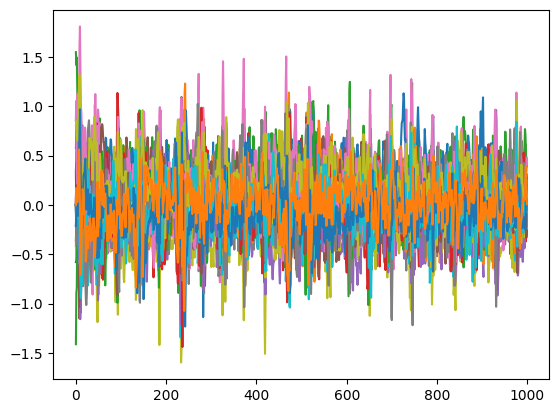

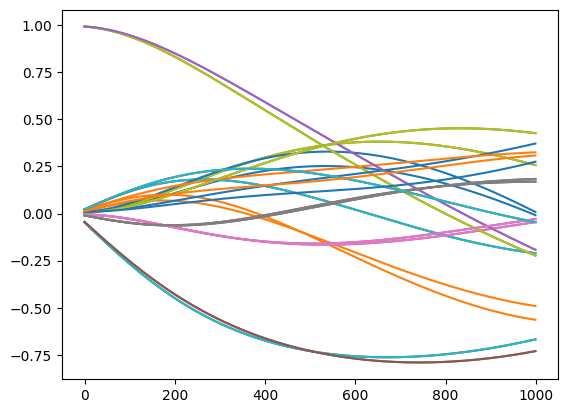

  0%|          | 1/1000 [00:05<1:25:53,  5.16s/it]

0.21988955326378345


 10%|█         | 100/1000 [01:14<10:31,  1.42it/s]

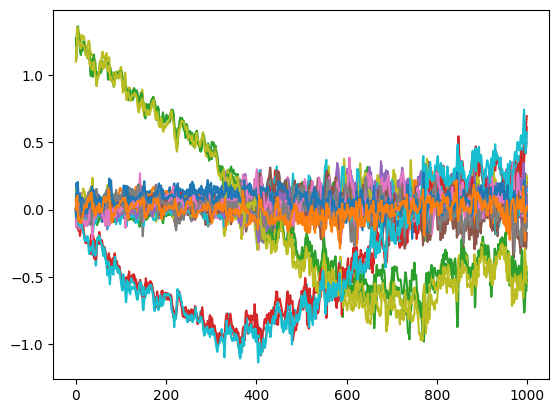

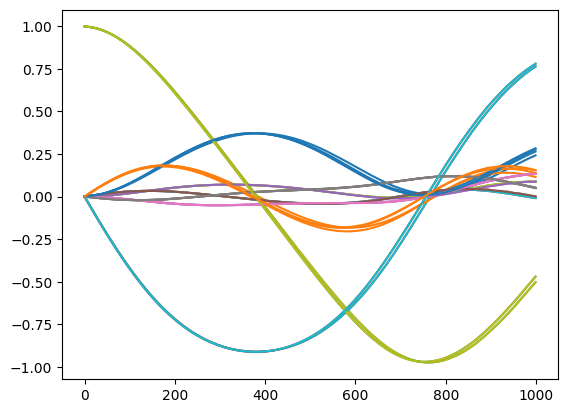

 10%|█         | 101/1000 [01:15<14:45,  1.02it/s]

0.06732830732927132


 20%|██        | 200/1000 [02:24<09:07,  1.46it/s]

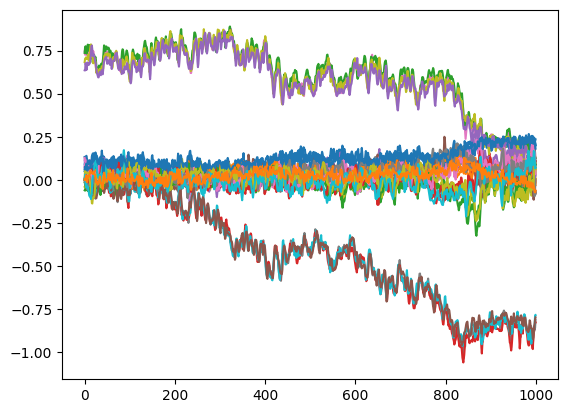

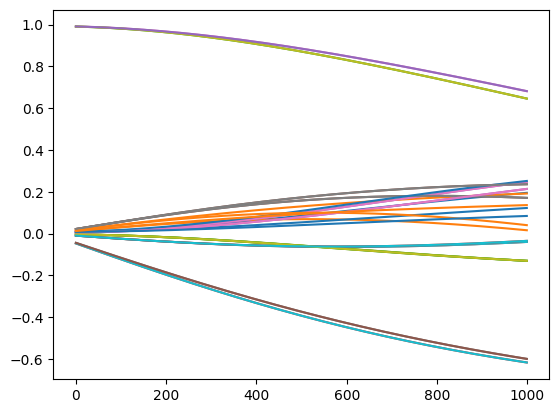

 20%|██        | 201/1000 [02:26<13:15,  1.00it/s]

0.043506967042809104


 30%|███       | 300/1000 [03:35<08:16,  1.41it/s]

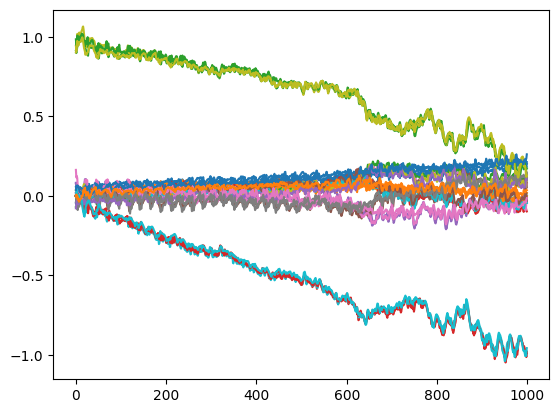

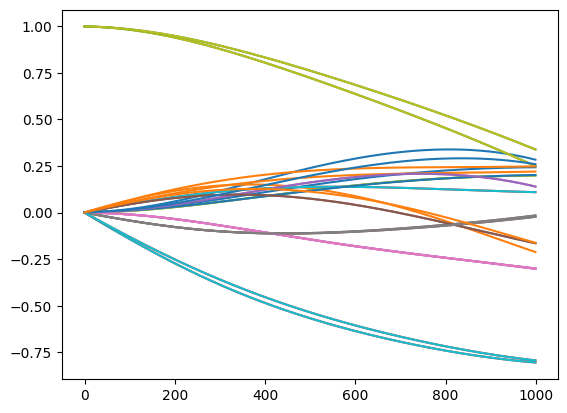

 30%|███       | 301/1000 [03:36<11:33,  1.01it/s]

0.03420000408083414


 40%|████      | 400/1000 [04:44<06:52,  1.46it/s]

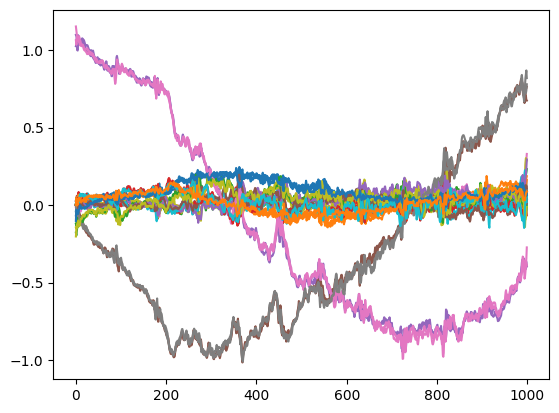

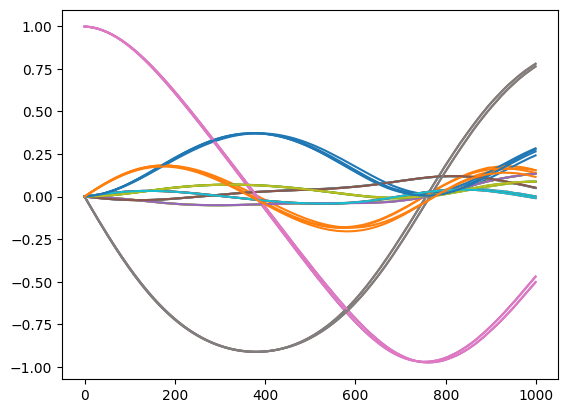

 40%|████      | 401/1000 [04:46<09:29,  1.05it/s]

0.028996950493207517


 50%|█████     | 500/1000 [05:55<05:44,  1.45it/s]

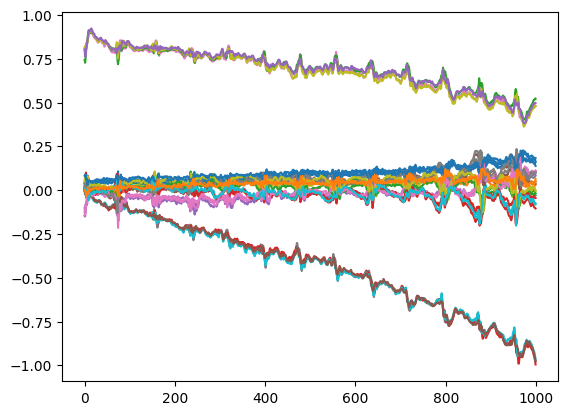

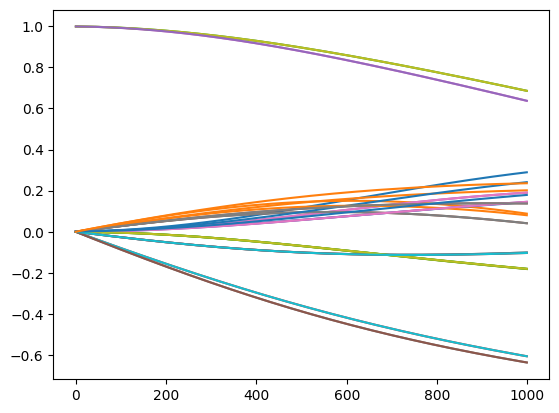

 50%|█████     | 501/1000 [05:57<08:23,  1.01s/it]

0.025742174364266707


 60%|██████    | 600/1000 [07:06<04:43,  1.41it/s]

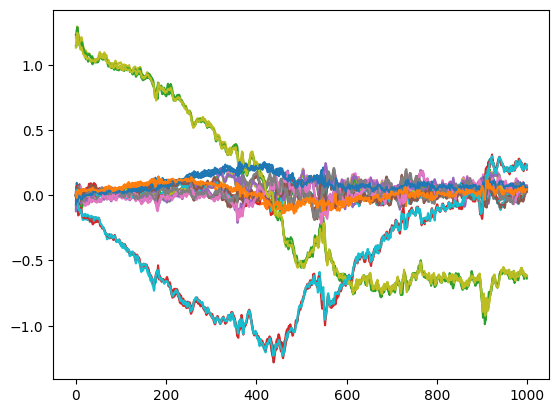

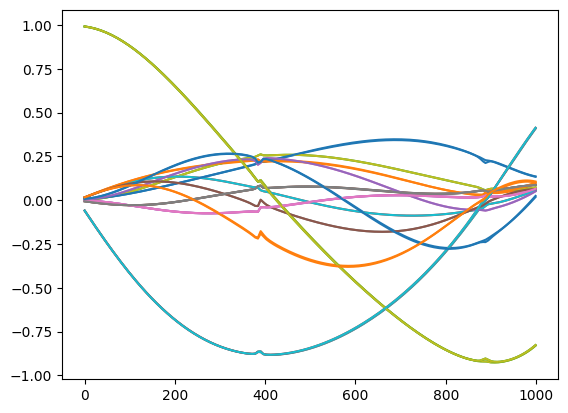

 60%|██████    | 601/1000 [07:08<06:40,  1.00s/it]

0.023234798676273694


 70%|███████   | 700/1000 [08:17<03:24,  1.47it/s]

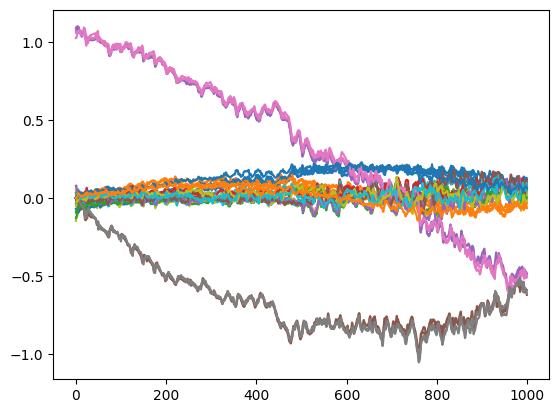

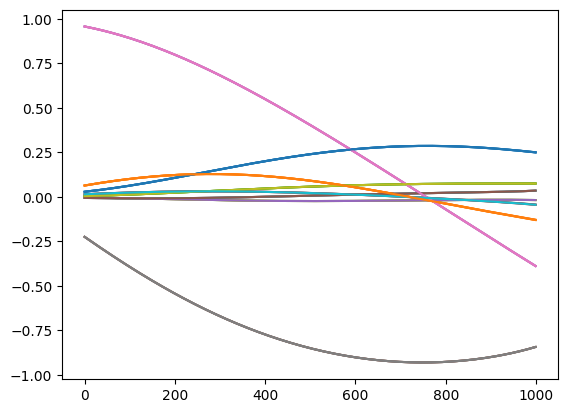

 70%|███████   | 701/1000 [08:18<04:42,  1.06it/s]

0.021327534414864027


 80%|████████  | 800/1000 [09:28<02:22,  1.41it/s]

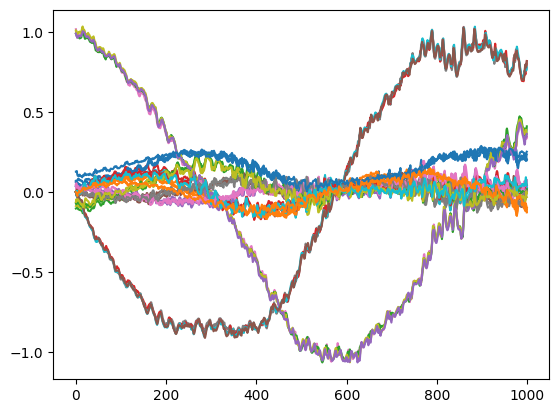

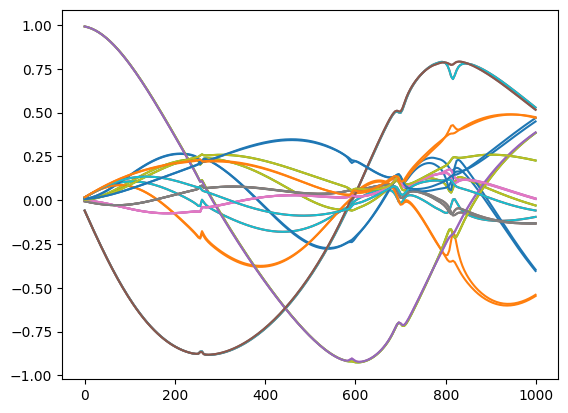

 80%|████████  | 801/1000 [09:29<03:18,  1.00it/s]

0.019863415686174564


 90%|█████████ | 900/1000 [10:39<01:10,  1.41it/s]

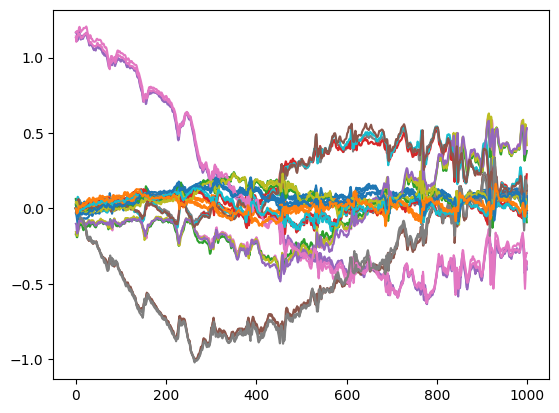

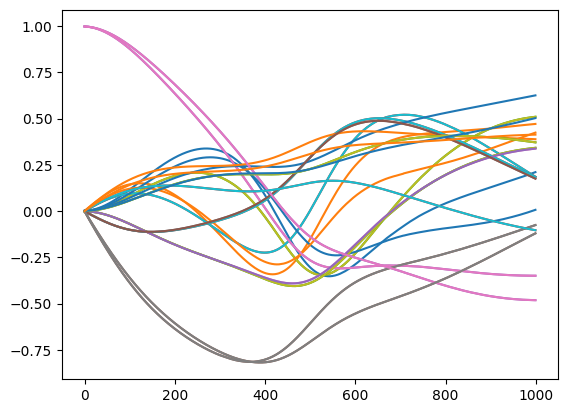

 90%|█████████ | 901/1000 [10:41<01:41,  1.03s/it]

0.018646557169645837


100%|██████████| 1000/1000 [11:50<00:00,  1.41it/s]


In [21]:
for epoch in tqdm(range(NUM_ITER)):
    for i, x in enumerate(dataloader):
        optim.zero_grad()

        x = x.to(device)

        #(1) Grab random measurements from training data
        M = random.uniform(M_min, M_max)

        kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

        sigma = random.uniform(Sigma_min, Sigma_max)

        z = torch.clone(x)
        z[:, :, missing_inds] = 0
        z = z + sigma*torch.randn_like(z)

        #(2) Input to the network and calcuate loss
        out = net.forward(z)

        train_loss = criterion(out, x)

        train_loss.backward()
        optim.step()

        #(3) Log
        loss_list.append(train_loss.item())

    if epoch%100 == 0:
        out = out.detach().cpu()
        x = x.detach().cpu()
        
        plt.figure()
        for i in range(out.shape[1]//2):
            plt.plot(out[0, 2*i])
            plt.plot(out[0, 2*i+1])
        plt.show()
        
        plt.figure()
        for i in range(x.shape[1]//2):
            plt.plot(x[0, 2*i])
            plt.plot(x[0, 2*i+1])
        plt.show()
        
        print(np.mean(loss_list))

In [22]:
save_pth = "/work2/04703/sravula/frontera/CurveFitting-DIP/pretrain_0.pt"

torch.save(net.state_dict(), save_pth)

# Test it on the test sample

In [23]:
x_test = torch.from_numpy(x_test).to(device).unsqueeze(0).type(torch.float32)

#(1) Grab random measurements from training data
M = 0.1

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

y = torch.clone(x_test)[:, :, kept_inds]

z = torch.clone(x_test)
z[:, :, missing_inds] = 0

#(2) Input to the network and calcuate loss
out = net.forward(z)

In [24]:
x_test = x_test.cpu().detach().numpy()
out = out.cpu().detach().numpy()
z = z.cpu().detach().numpy()

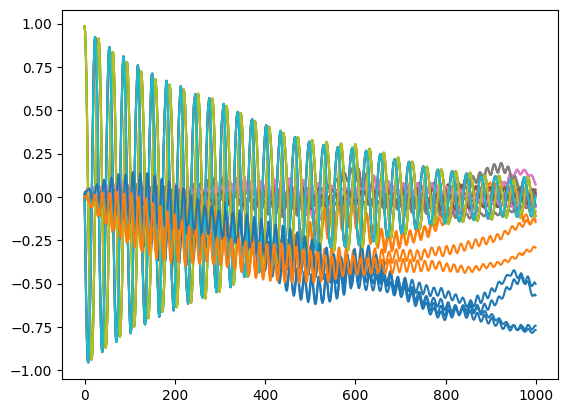

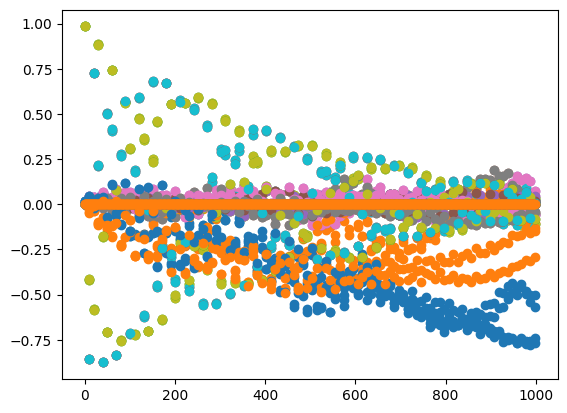

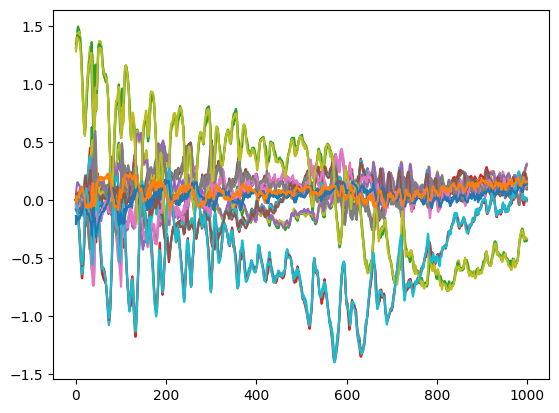

In [25]:
plt.figure()
for i in range(x_test.shape[1]//2):
    plt.plot(x_test[0, 2*i])
    plt.plot(x_test[0, 2*i+1])
plt.show()

plt.figure()
for i in range(z.shape[1]//2):
    plt.scatter(np.arange(z.shape[-1]), z[0, 2*i])
    plt.scatter(np.arange(z.shape[-1]), z[0, 2*i+1])
plt.show()

plt.figure()
for i in range(out.shape[1]//2):
    plt.plot(out[0, 2*i])
    plt.plot(out[0, 2*i+1])
plt.show()